# by

[video](https://jhjhm.zoom.us/rec/share/8x0apHVqmnUHnuBfzLXMuvRRXkExSGeoQAw5rEs9OvKSmzs1bvhPfLD2pGu6NRY.BYToPUwpMdnR-h25?startTime=1681414214000)

The figure below outlines a schema of what we covered last week and attempts to generalize it to several scenarios beyond what we might have time to cover in 5 weeks. For instance, you may replace `sum` with `count`, `regression` with `kappa statistic estimation` (as one of your classmates did), or yet still `lincom` with a `matrix define m=r(table)` step. 

For the latter case, the matrix cells will each contain `r()` class macros, which you may capture and format in a local macro like so:

`local b_age: di %3.1f m[1,4]`

Where `m` is the matrix you defined and `m[1,4]` is the value in row1, column4. And here is a script that outputs `r(table)` following a Cox regression into an excel file:

[rtable.do](https://raw.githubusercontent.com/jhustata/book/main/rtable.do)

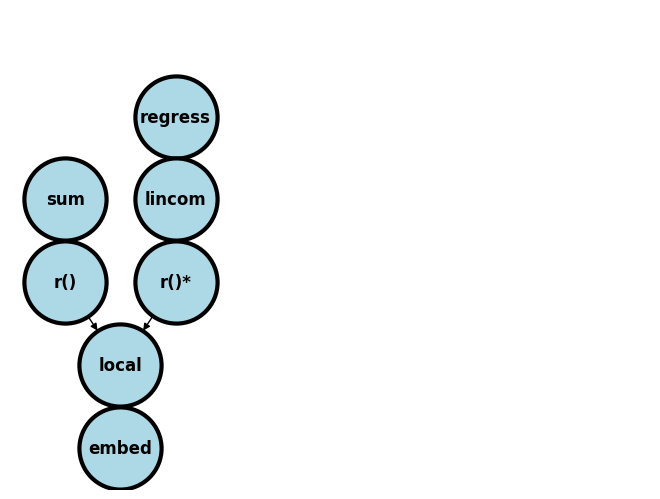

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
#import numpy as np
#import sklearn as skl
# 

#plt.figure(figsize=[2, 2])
G = nx.DiGraph()
#G.add_node(" ",  pos = (0, 3) )
G.add_node("regress",  pos = (1, 4) )
G.add_node("sum", pos = (0, 3) )
G.add_node("lincom", pos = (1, 3) )
G.add_node("r()", pos = (0, 2) )
G.add_node("r()*", pos = (1, 2) )
G.add_node("local", pos = (.5, 1))
G.add_node("embed", pos = (.5, 0))
G.add_edges_from([      ("regress", "lincom")])
G.add_edges_from([("sum", "r()"),     ("lincom", "r()*") ])
G.add_edges_from([("r()", "local"), ("r()*", "local")])
G.add_edges_from([("local","embed")])
nx.draw(G, 
        nx.get_node_attributes(G, 'pos'), 
        with_labels=True, 
        font_weight='bold', 
        node_size = 3500,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.5, 5.3])
ax.set_ylim([-.5, 5.3])
plt.show()

I've not illustrated where `e()` and `c()` fit in this scheme. But once you appreciate that `r()` values in memory can be revealed using `return list`, `e()` values using `ereturn list`, and `c()` values using `creturn list` then you will be set for life!!

The local macros you define will ultimately be embedded in programs you write or the text, tables, and figures of your final manuscripts.

We've seen how to embed a local macro in text:

```stata

di "We have seen how to embed a `local macro' in text, but such macros may be embeded in tables and graphs as well!"

```

Remember: 

1. names: r(), e(), c()
2. content: return, estimates, constants
3. these system-defined local macros may then be formatted to suit your needs in a user-defined local macro


In context of the first three weeks here is where things stand:

1. `pwd` —> dofile structure, working directory, location of output
2. `r(mean)` —> macros, local system-defined, user-defined 
3. `by` —> prelude to `program define`

For today's session, `by`, you'll use [transplants.dta](transplants.dta) to demonstrate a few useful commands that we will put to good use over the coming weeks. You should be able to do most of this session on your own and at your convenience since it merely exposes you to various commands but not in the context of any specfic task.

```Stata

use transplants, clear

```

What if we want a variable of the total number of records in each ABO blood type?

```Stata

bys abo: gen cat_n = _N
```

So what did this code achieve?

```Stata

tab cat_n
```

Let's add labels to the groups:

```Stata
#delimit ;
lab define abo_lab
   1 "A"
   2 "B"
   3 "AB"
   4 "O"
;
#delimit cr

lab values abo abo_lab
```

Now lets tabulate once again:

```Stata

tab abo
```
Nice!

Ok. Do you remember these commands?

```Stata
di c(N)

di c(k)
```

Lets create a `disturbance` to our setup to learn a few additional commands and their value to us:

```Stata

qui do https://raw.githubusercontent.com/jhustata/book/main/sample-keep.ado
```

Is that a new command? Or are you already familiar with it? How about this:

```Stata
samplekeep
```

What just happened?

```Stata
di c(N)

di c(k)
```

Let's rerun earlier commands to restore our sanity!

```Stata
tab abo
```

Ok, then. It was a temporary disturbance and peace was `restored`!! We will talk more about the `preserve` and `restore` commands, often used together. 

Back to the `by` command:

```Stata
bys abo: egen age_byabo = mean(age)
```

Any idea what this command just achieved?

```Stata
codebook age_byabo
```

What do you notice? Only four unique values! The `egen` command, like the `gen` command is used to define new variables in the dataset. However, the `gen` command applies values at the level of the individual. The `egen` command does so `by` group and yields summary statistics. To learn more type `h egen`.

```Stata
qui regress age i.abo
local abo_H: di %3.2f e(r2_a)*100

di "ABO blood group may influence survivorship on a kidney transplant waitlist. Blood type O are universal donors whereas type AB are universal recipients. Hypothetically, these two represent the extremes and types A and B should be in between. But in this cross-sectional dataset blood group explains only `abo_H'% of the variance in age. Only a longitudinal data structure would be in position to explain variance in survivorship"
```

Enough! I don't wish to trouble you with a bogus hypothesis but merely wish to explore return values from a regression! From whence, for instance, does `e(r2_a)` come? Where does it fit into our schema? (**Hint:** `return list`, `ereturn list`, `creturn list`)

```Stata
lincom _b[3.abo]
```

What blood group has value 3?

```Stata
return list
di %3.2f r(p)
di %3.2f r(estimate)
```

After a regression we may type `ereturn list` for all sorts of estimated values:

```Stata
matrix define b = e(b)
matrix list b
di b[1,3]
```
#

You should explore the following commands on your own:

```Stata
tab rec_education, sum(age)
regress wait_yrs age, level(90)
count if age > 50
count if inrange(age,50,90)
list age dx rec_education in 1/5

//di c(N) " & " c(k)
use age dx using transplants, clear
use transplants in 1/50, clear
use transplants in 44
use transplants if rec_work==1
use a* p* using transplants in 1/100

//describe
describe, simple
describe, short
describe a*
describe using transplants.dta 
describe r*, fullnames

//codebook
codebook
codebook rec_education rec_work abo
codebook a* e*, compact
codebook, problems

//list 
list 
list prev_ki wait_yrs if race==9
list *date in 1/10
list dx in 1/10, clean noobs
list age, fast

//count
count
count if rec_work==1
count if rec_work!=1
count if bmi<20 | bmi > 35
count if bmi>25 & bmi <30
count if !(age>18)
count if inrange(wait_yrs,4,6)
count if !inlist(gender,0,1)

//tabulate
tab abo
tab abo rec_hcv
tab gender, sum(age)
tab dx gender if age<40
tab dx gender,row
tab dx gender,col nofreq

tab dx gender, col nofreq chi2
return list 

//summarize
sum
return list //not very useful; see schema above

sum age wait_yrs
return list //much more useful!

sum age wait_yrs, detail

//missingness
count if bmi > 30
count if bmi > 1000 //wha? 
sum bmi //whats going on?
assert c(N) == r(N) //when do these diverge?
tab bmi if bmi > 1000
tab bmi if bmi > 1000, missing

count if bmi==.
count if bmi==.a
count if missing(bmi)
```

Let's discuss [missingness](https://stats.oarc.ucla.edu/stata/faq/how-can-i-recode-missing-values-into-different-categories/) as its relevance emerges.

```Stata
//manipulating data
gen age_lastyear=age-1
gen any_college=(rec_educ>=3)
g youngman=(age<40>)&(gender==0)
```

#

Variable **types**

`byte`: integer range -127 to 100

`int`: integer range -32767 to 32740

`long`: integer range +/- 2 billion

`float`: decimal, range +/- $10^{38}$

`double`: decimal, range +/- $10^{307}$

`strings`: e.g. str5 = string of length 5


You'll need to specify the variable types as you start to right flexible programs with the `program define` command and `syntax` command with options such as`, time(varname) event(varname) tmax(float)`

If you wish to better understand these variables types, please explore those available to you in `transplants.dta`.

```stata
use transplants, clear
describe
```

```Stata
//generate
g byte young=(age<30>)
g age_f=age if gender==1
g age_spline=(age>40)*(age-40)

//_n and _N
g new_id=_n
gen total_records=_N
g percentile=100*_n/_N

//drop/keep
keep age gender bmi fake_id ra*
drop end_date

//remember: to load the original dataset again
use transplants, clear
keep in 1/100
drop if wait_yrs<1
keep if prev_ki==1
drop if age<18 & abo==2

//load data again
use transplants, clear
replace prev=0
replace wait_yrs=5 if wait_yrs>5
replace gender=gender+1
replace bmi=. if !inrange(bmi,17,50)

//rename
rename age age_at_transplant
rename gender female

use transplants, clear
rename (age gender)(age_at_transplant female)

//sort, gsort
list in 1/10 
sort age
list in 1/10
sort age dx
list in 1/10
gsort -age dx -race 
list in 1/10

//recode
recode rec_education (3 4 5 =9)
recode dx (1=1)(2=2)(*=9)
recode gender (0=1)(1=0),gen(male)

//display
sum wait_yrs
di "variable" _col(20) "mean"
di "wait time" _col(20) r(mean)

//capture
capture sum nonexistent_variable
capture di 4+3
capture di 4+

//assert 
assert age<100
assert end_date>=transplant_date
assert inlist(gender,0,1)
assert 2<1
assert 0

//recode+label
#delimit ;
recode race 
    (1=0 "Cauc")
    (2=1 "AA)
    (4=2 "Hisp/Latino")
    (5/9=3 "Other"),
        gen(race_cat)
;
#delimit cr

//preserve & restore
sum age

preserve
    drop if age<r(mean)
    sum age
restore 

sum age
```